# Index

1. [Problem Statement](#PS)
2. [Data Preparation](#Data)
    1. [Routing](#Route)
    2. [Disaster Radius](#Dis)
    3. [Edge Manipulation and Visualizations](#EM)
3. [EDA](#EDA)
    1. [Data Cleaning](#Clean)
    2. [Statistics](#Stats)
4. [Modeling](#Modeling)
    1. [Flattened List Model Selection](#FLM)
    2. [Logistic Regression Model](#LRM)
    3. [Ada with CountVectorizer vs Ti-Dif](#Ada)
    4. [Ada with Title and CountVectorizer/Ti-Dif](#AdaTitle)
    5. [Column Selection/recap](#Col)
5. [Predictive Model Conclusion](#Conclusion)

In [1]:
#Import Libraries

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import geopandas as gpd
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
ox.config(use_cache=True, log_console=True)
ox.__version__

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## 1. Problem Statement <a id = "PS"></a>

In [3]:
#YOu need to write this

## 2. Data Collection/Import Medford <a id = "Data"></a>

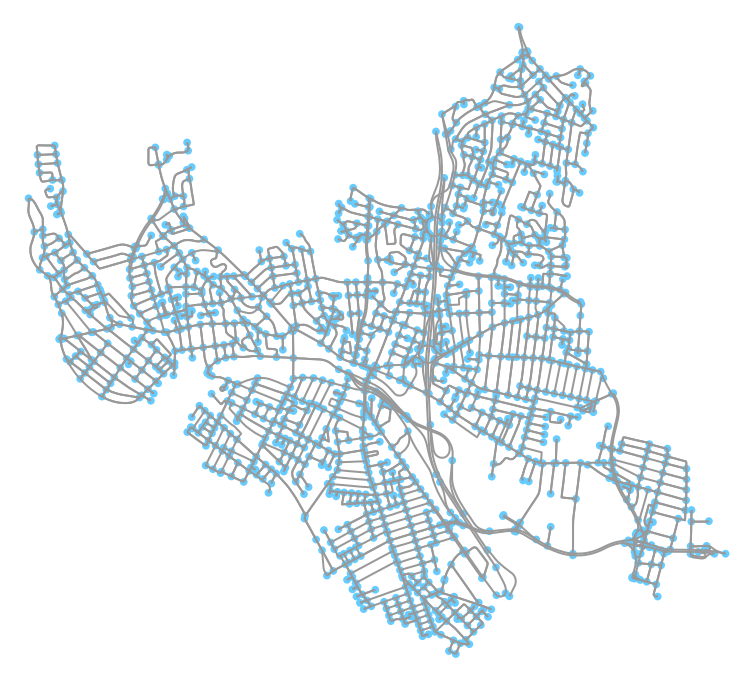

In [4]:
# get a graph for some city
place = {'city' : 'Medford',
         'state' : 'MA',
         'country' : 'USA'}
medford = ox.graph_from_place(place, network_type='drive')
fig, ax = ox.plot_graph(medford)

In [5]:
# what sized area does our network cover in square meters?
medford_proj = ox.project_graph(medford)
nodes_proj = ox.graph_to_gdfs(medford_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

21010917.099306576

In [6]:
# show basic stats about the network
ox.basic_stats(medford_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

{'n': 1569,
 'm': 3862,
 'k_avg': 4.922880815806246,
 'intersection_count': 1361,
 'streets_per_node_avg': 2.905672402804334,
 'streets_per_node_counts': {0: 0, 1: 208, 2: 4, 3: 1094, 4: 254, 5: 9},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.1325685149776928,
  2: 0.0025493945188017845,
  3: 0.6972594008922881,
  4: 0.16188655194391333,
  5: 0.0057361376673040155},
 'edge_length_total': 397167.3859999986,
 'edge_length_avg': 102.83982030036215,
 'street_length_total': 239165.9069999998,
 'street_length_avg': 106.48526580587702,
 'street_segments_count': 2246,
 'node_density_km': 74.67546478738817,
 'intersection_density_km': 64.77584931525513,
 'edge_density_km': 18902.90576669337,
 'street_density_km': 11382.935160307354,
 'circuity_avg': 1.03910028730363,
 'self_loop_proportion': 0.0020714655618850335,
 'clean_intersection_count': 1115,
 'clean_intersection_density_km': 53.06765024725163}

### Edge and Node Dataframe

In [7]:
# Edge and Node projection
nodes_med, edges_med = ox.graph_to_gdfs(medford, nodes=True, edges=True)

In [8]:
nodes_med.head(2)

,highway,osmid,ref,x,y,geometry
66478081,turning_circle,66478081,NaN,-71.100780,42.429287,POINT (-71.1007798 42.4292871)
1095962629,traffic_signals,1095962629,NaN,-71.110312,42.415123,POINT (-71.1103119 42.4151234)


In [9]:
nodes_med.shape

(1569, 6)

In [10]:
edges_med.head(2)

,access,bridge,geometry,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,u,v,width
0,NaN,NaN,"LINESTRING (-71.1007798 42.4292871, -71.100584...",residential,NaN,0,2,86.903,NaN,Leon Circle,False,9038637,NaN,66478081,66479406,10.1
1,NaN,NaN,"LINESTRING (-71.1103119 42.4151234, -71.110340...",primary,NaN,0,2,6.594,NaN,Main Street,True,518430928,MA 38,1095962629,66439794,19.5


In [11]:
#Long Lat information 
nodes_med[["x","y"]].describe()

,x,y
count,1569.000000,1569.000000
mean,-71.107867,42.419430
std,0.015947,0.010365
min,-71.145410,42.396426
25%,-71.118687,42.411989
50%,-71.105661,42.420096
75%,-71.095526,42.426626
max,-71.073105,42.444456


In [12]:
#Random Node Sampler
nodes_med[["x","y"]].sample(1).values

array([[-71.110072 ,  42.4313414]])

## 2a. Routing<a id = "Route"></a>

In [13]:
#Random Point Generator
def random_point(lower = -180, higher = 180):
    return (np.random.uniform(low=lower, high=higher),
            np.random.uniform(low=lower, high=higher))

print(random_point())

(-117.27783053450149, -2.94203840405396)


In [16]:
random_point_A = random_point()
random_point_B = random_point()

# get the nearest network node to each random point
orig_node = ox.get_nearest_node(medford, random_point_A)
dest_node = ox.get_nearest_node(medford, random_point_B)

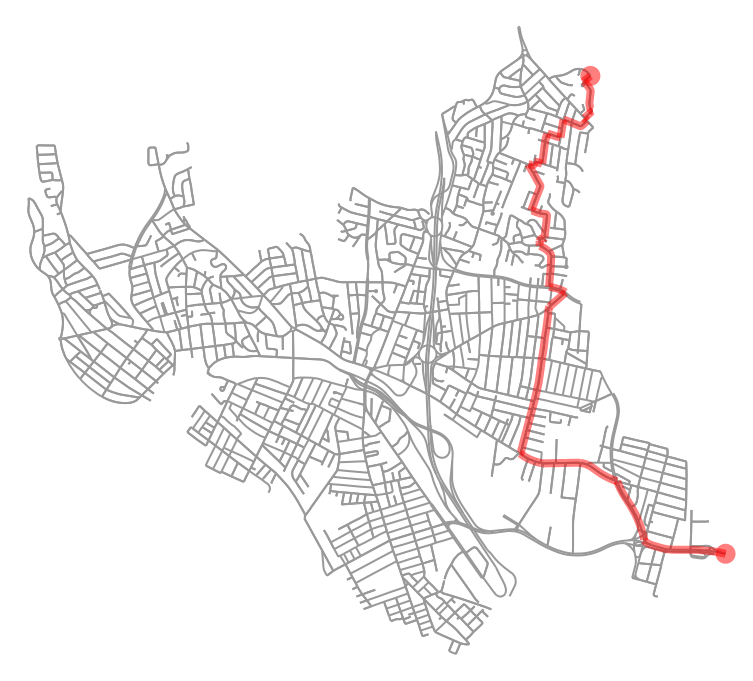

In [17]:
# find the route between these nodes then plot it
route = nx.shortest_path(medford, orig_node, dest_node, weight='length')
fig, ax = ox.plot_graph_route(medford, route, node_size=0)

In [18]:
# Length of route in meters
nx.shortest_path_length(medford, orig_node, dest_node, weight='length')

6414.016

In [20]:
# Absolute Distance between two nodes (as the crow flies)
ox.great_circle_vec(medford.node[orig_node]['y'], medford.node[orig_node]['x'],
                    medford.node[dest_node]['y'], medford.node[dest_node]['x'])

4228.674762903878

## 2b. Disaster Radius<a id = "Dis"></a>

In [21]:
nodes_med[["y","x"]].sample(1).values[0]

array([ 42.419184, -71.095607])

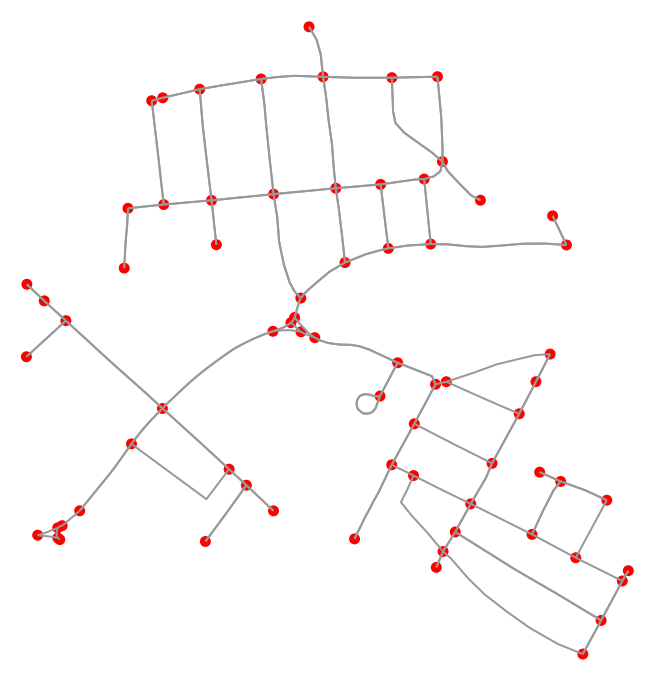

In [24]:
# define a point at the corner of a box
location_point = nodes_med[["y","x"]].sample(1).values[0]

# create network from point, inside bounding box of N, S, E, W each 1750m from point
disaster = ox.graph_from_point(location_point,
                         distance=1000*np.random.uniform(),
                         distance_type='network',
                         network_type='drive')
disaster = ox.project_graph(disaster)
fig, ax = ox.plot_graph(disaster, node_size=30, node_color='red')

In [25]:
nodes_dis, edges_dis = ox.graph_to_gdfs(disaster)

In [26]:
edges_dis.head(2)

,access,bridge,geometry,highway,junction,key,lanes,length,name,oneway,osmid,ref,u,v,width
0,NaN,NaN,LINESTRING (325213.769837582 4698113.571005878...,residential,NaN,0,2,40.366,Marshall Street,True,9038041,NaN,66473216,66435168,12.2
1,NaN,NaN,LINESTRING (325085.1234775737 4698601.80179178...,residential,NaN,0,2,74.278,Prescott Street,False,9038821,NaN,66467074,66453406,8.5


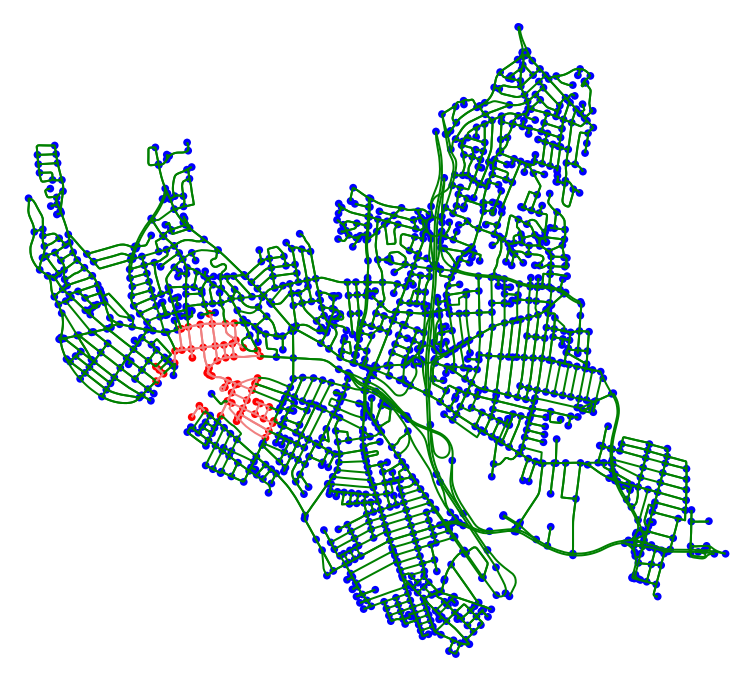

(<Figure size 650.491x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11fffd940>)

In [27]:
#Set Colors
ec = ['lightcoral' if i in disaster.edges() else 'green' for i in medford.edges()]
nc = ['red' if i in disaster.nodes() else 'blue' for i in medford.nodes()]

#Plot energency grid
ox.plot_graph(medford, node_size=15, node_color = nc ,edge_color=ec)


In [28]:
live = []

for i in medford.edges():
    if i not in disaster.edges():
        live.append(i[0])

In [29]:
live = edges_med[edges_med["u"].isin(live)]

In [30]:
live.size

60256

In [31]:
edges_med.size

61792

In [32]:
med_live = ox.gdfs_to_graph(nodes_med, live)

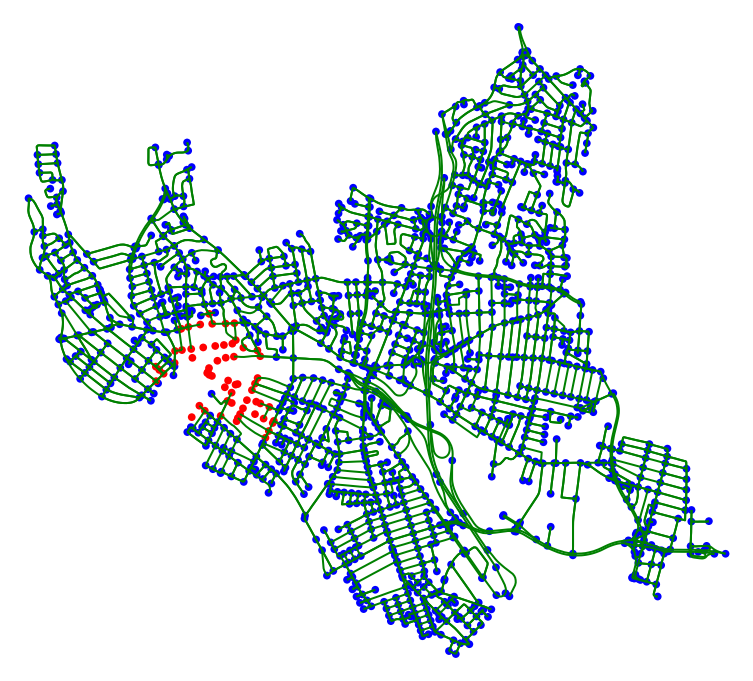

In [34]:
ox.plot_graph(med_live, node_size=15, node_color = nc ,edge_color="g");

## 2c. Edge Manipulation and Visualizations<a id = "EM"></a>

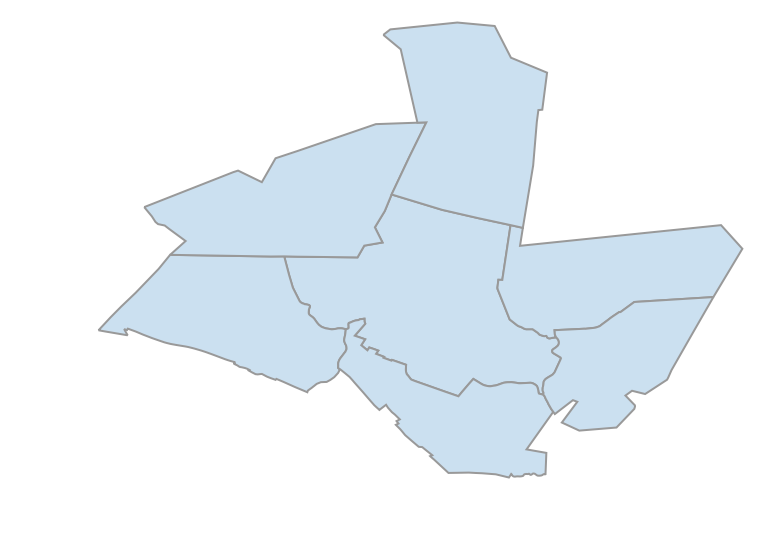

In [36]:
# get the boundary polygons for neighboring cities, save as shapefile, project to UTM, and plot
place_names = ['Medford, MA, USA', 
               'Arlington, MA, USA',
               'Somerville, MA, USA',
               'Malden, MA, USA',
#                'Melrose, MA, USA',
               'Winchester, MA, USA',
               'Stoneham, MA, USA',
               'Everett, MA, USA',
              ]
medford_area = ox.gdf_from_places(place_names)
fig, ax = ox.plot_shape(medford_area)

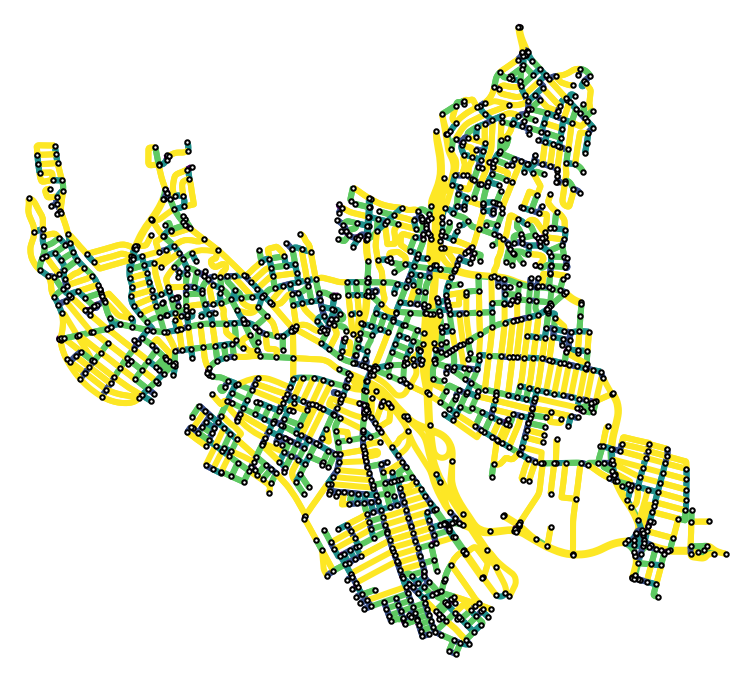

In [39]:
# Roads colored by edge length
ec = ox.get_edge_colors_by_attr(medford, attr='length')
fig, ax = ox.plot_graph(medford, node_color='w', node_edgecolor='k', node_size=5, 
                           node_zorder=3, edge_color=ec, edge_linewidth=3)

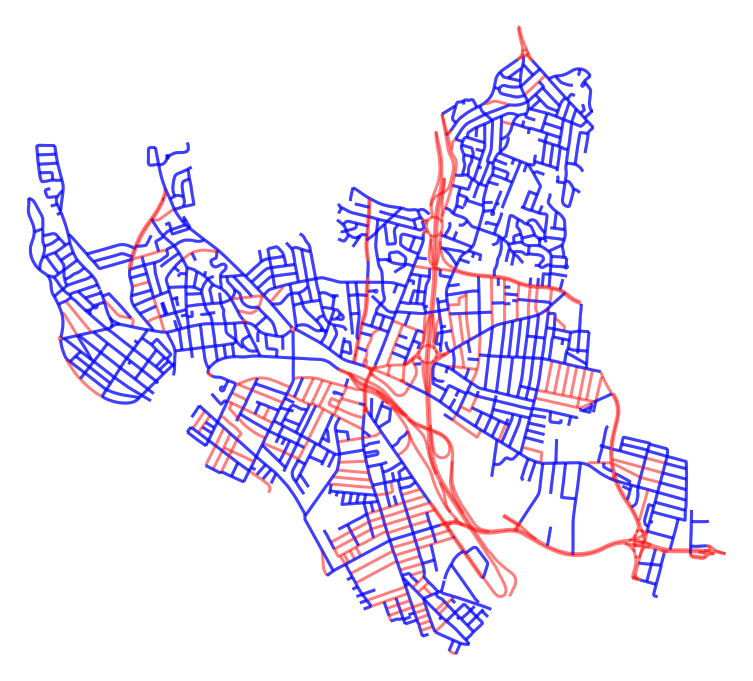

In [40]:
# highlight one-way roads
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in medford.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(medford, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5)

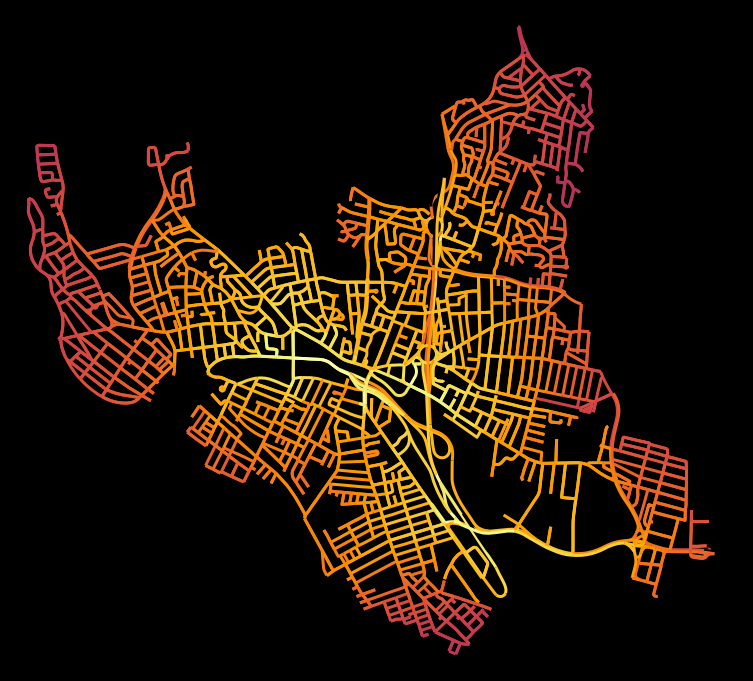

In [42]:
# edge closeness centrality: convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(medford))

# list of edge values for the orginal graph
ev = [edge_centrality[edge + (0,)] for edge in medford.edges()]

# color scale converted to list of colors for graph edges
norm = colors.Normalize(vmin=min(ev)*0.8, vmax=max(ev))
cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
ec = [cmap.to_rgba(cl) for cl in ev]

# color the edges in the original graph with closeness centralities in the line graph
fig, ax = ox.plot_graph(medford, bgcolor='k', axis_off=True, node_size=0,
                        edge_color=ec, edge_linewidth=1.5, edge_alpha=1)